In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터 전처리

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta, time, datetime
from tqdm import tqdm
import math
# pandas max row 
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [3]:
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100

In [4]:
data = pd.read_csv('/content/drive/MyDrive/KDT/total_data.csv')
data = data[9:27025] #drop unknwon period(~2017060108, 2020070100~ )
data = data.reset_index(drop = True)
data.columns = ['datetime','solar_result','temp','rain_t','rain_r',
                    'hum','wins', 'wind','sky','altitude','azimuth']
data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y%m%d%H')
data.head()

,datetime,solar_result,temp,rain_t,rain_r,hum,wins,wind,sky,altitude,azimuth
0,2017-06-01 09:00:00,33.12,21.000000,0.0,0.0,65.000000,2.400000,111.000000,1.0,44.23,92.42
1,2017-06-01 10:00:00,50.16,21.333333,0.0,0.0,65.000000,2.333333,112.000000,1.0,NaN,NaN
2,2017-06-01 11:00:00,96.72,21.666667,0.0,0.0,65.000000,2.266667,113.000000,1.0,NaN,NaN
3,2017-06-01 12:00:00,120.96,22.000000,0.0,0.0,65.000000,2.200000,114.000000,1.0,76.04,158.50
4,2017-06-01 13:00:00,118.80,21.333333,0.0,0.0,63.333333,2.433333,107.666667,1.0,NaN,NaN


#01. 학습 데이터 전처리

In [5]:
dataset = data.loc[:,'solar_result' :].astype('float')
dataset.index = data['datetime']
dataset.isnull().sum()

solar_result        0
temp                0
rain_t              0
rain_r              0
hum                 0
wins                0
wind                0
sky                 0
altitude        22512
azimuth         22512
dtype: int64

#SARIMA

In [6]:
# !pip install pandas_datareader

import os

import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

!pip install pmdarima
from pmdarima.arima import auto_arima

import seaborn as sns

%matplotlib inline

import itertools

import warnings
warnings.filterwarnings('ignore')

###1.Data

In [7]:
dataset = dataset.drop(['temp','rain_t','rain_r',
                    'hum','wins', 'wind','sky','altitude','azimuth'], axis=1)
dataset.head()

,solar_result
datetime,
2017-06-01 09:00:00,33.12
2017-06-01 10:00:00,50.16
2017-06-01 11:00:00,96.72
2017-06-01 12:00:00,120.96
2017-06-01 13:00:00,118.80


In [8]:
data['day'] = data['datetime'].apply(lambda x : x.strftime('%Y%m%d'))
data['day'] = pd.to_datetime(data['day'], format = '%Y%m%d')
data= data.groupby('day').agg({'solar_result' : 'sum'})
data.head()

,solar_result
day,
2017-06-01,725.52
2017-06-02,1019.28
2017-06-03,997.20
2017-06-04,1019.04
2017-06-05,1001.28


In [9]:
data

,solar_result
day,
2017-06-01,725.52
2017-06-02,1019.28
2017-06-03,997.20
2017-06-04,1019.04
2017-06-05,1001.28
...,...
2020-06-27,698.40
2020-06-28,992.40
2020-06-29,318.72


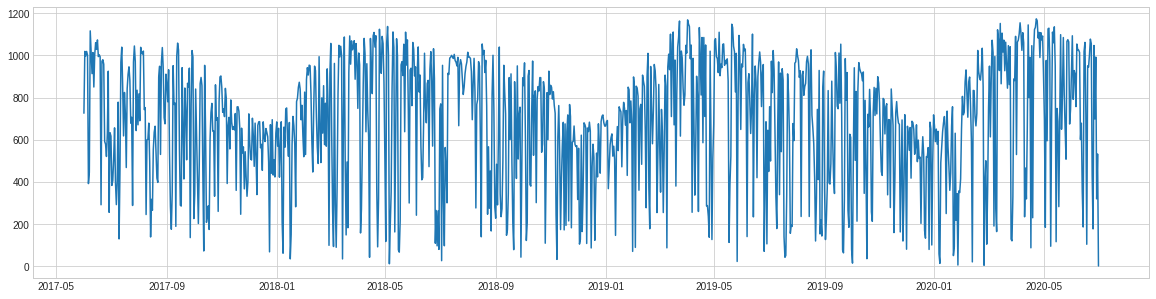

In [10]:
plt.figure(figsize=(20,5))
plt.plot(data)
plt.show()

Seasonal decomposition plot : Seasonal decomposition using moving average
https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

*   Observed : observed data
*   Trend : The estimated trend component
*   Seasonal : The estimated seasonal component
*   resid : The estimated residuals

[시계열분해법](https://leedakyeong.tistory.com/entry/%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%B6%84%ED%95%B4%EB%9E%80Time-Series-Decomposition-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%B6%84%EC%84%9D%EC%9D%B4%EB%9E%80-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%9E%80-%EC%B6%94%EC%84%B8Trend-%EC%88%9C%ED%99%98Cycle-%EA%B3%84%EC%A0%88%EC%84%B1Seasonal-%EB%B6%88%EA%B7%9C%EC%B9%99-%EC%9A%94%EC%86%8CRandom-Residual)


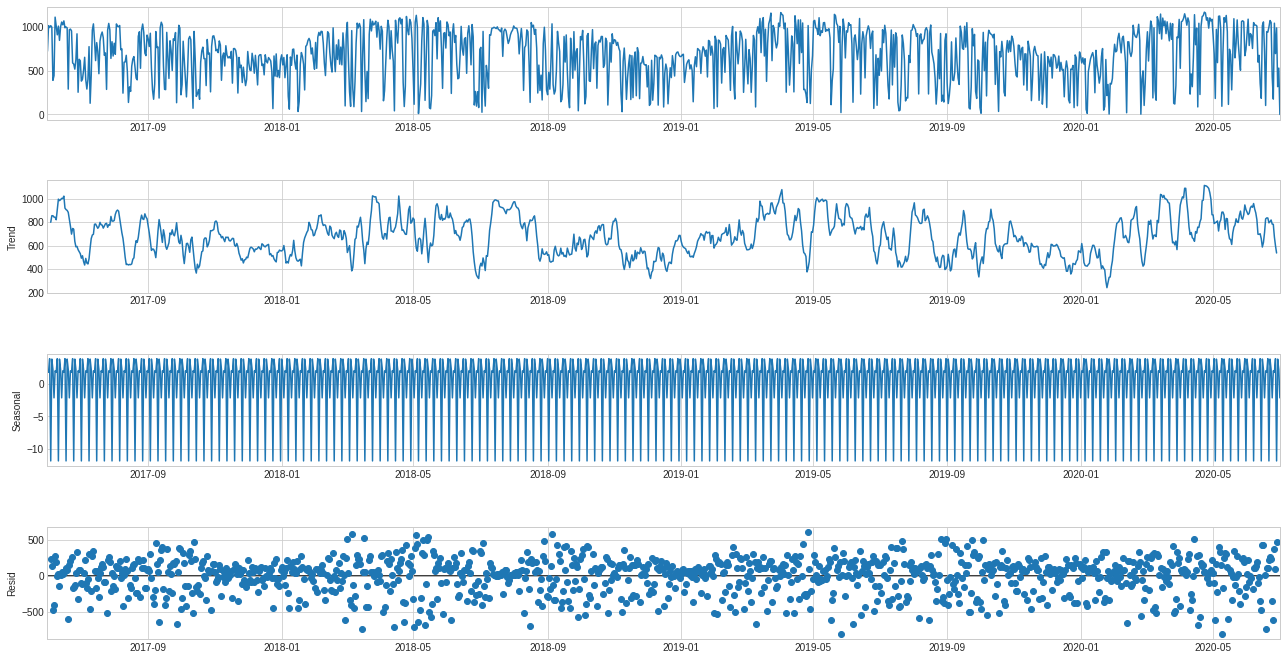

In [11]:
# decompotion = sm.tsa.seasonal_decompose(dataset['solar_result'], model='additive', period =1)

# decompotion = seasonal_decompose(dataset['solar_result'], model='additive', period =1)
# # TypeError: seasonal_decompose() got an unexpected keyword argument 'period'

decompotion = seasonal_decompose(data, model='additive')
fig = decompotion.plot()
fig.set_size_inches(20,10)
plt.show()

###2.Identify Model to be Tentatively Entertainted

In [12]:
# Train:Test = 8:2
train_data, test_data = train_test_split(data, test_size = 0.2, shuffle=False)

In [13]:
train_data.head(10)

,solar_result
day,
2017-06-01,725.52
2017-06-02,1019.28
2017-06-03,997.20
2017-06-04,1019.04
2017-06-05,1001.28
2017-06-06,391.20
2017-06-07,445.20
2017-06-08,1116.72
2017-06-09,1019.76


ACF, PACF plot

https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html
https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html

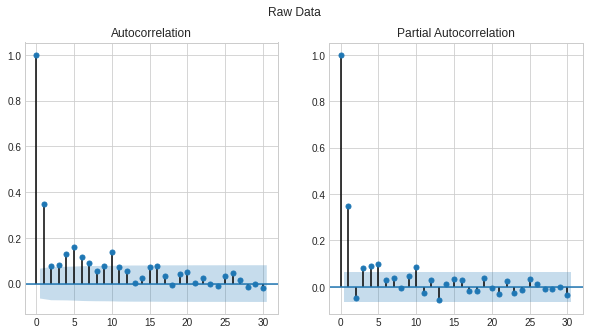

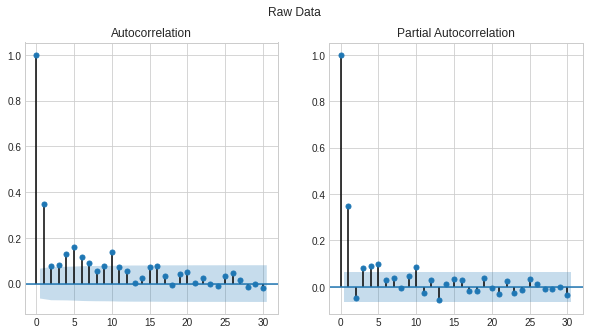

In [14]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0]) # 스퀴즈(Squeeze) - 1인 차원을 제거한다.
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1])
# sm.graphics.tsa.plot_acf(train_data, lags=30, ax=ax[0])
# sm.graphics.tsa.plot_pacf(train_data, lags=30, ax=ax[1])

# Q) 왜 그래프가 두개나 나오지?
# 결과는 소멸하는 sin함수 형태로서 AR모델이랑 잘맞는 모델로서 나옴

Differencing
차분 : 현 시점 데이터에서 d시점 이전 데이터를 뺀 것

In [15]:
# diff_train_data = train_data.copy()
# diff_train_data = diff_train_data['solar_result'].diff() # 차분 default 값 1임
# diff_train_data = diff_train_data.dropna() # 차분을 하다보면 마지막 값의 경우 길이가 맞지 않아서 결측치가 발생되는데 이러한 부분이 계속 남아있으면 예측이 잘 안되므로 결측치 제거
# print('###### Raw Data ######')
# print(train_data)
# print('### Differenced Data ###')
# print(diff_train_data)

# # 차분 결과 aic가 너무 높게 나와서 차분은 생략

In [16]:
# # Differenced data plot

# plt.figure(figsize=(12,8))
# plt.subplot(211)
# plt.plot(train_data['solar_result'])
# plt.legend(['Raw Data (Nonstationary)'])
# plt.subplot(212)
# plt.plot(diff_train_data, 'orange') # first difference (t - (t-1))
# plt.legend(['Differenced Data (Stationary)'])
# plt.show()

# # 차분 결과 aic가 너무 높게 나와서 차분은 생략

In [17]:
# # ACF, PACF plot
# fig, ax = plt.subplots(1,2,figsize=(10,5))
# fig.suptitle('Raw Data')
# sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0]) # 스퀴즈(Squeeze) - 1인 차원을 제거한다.
# sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1])

#  # 차분 결과 aic가 너무 높게 나와서 차분은 생략

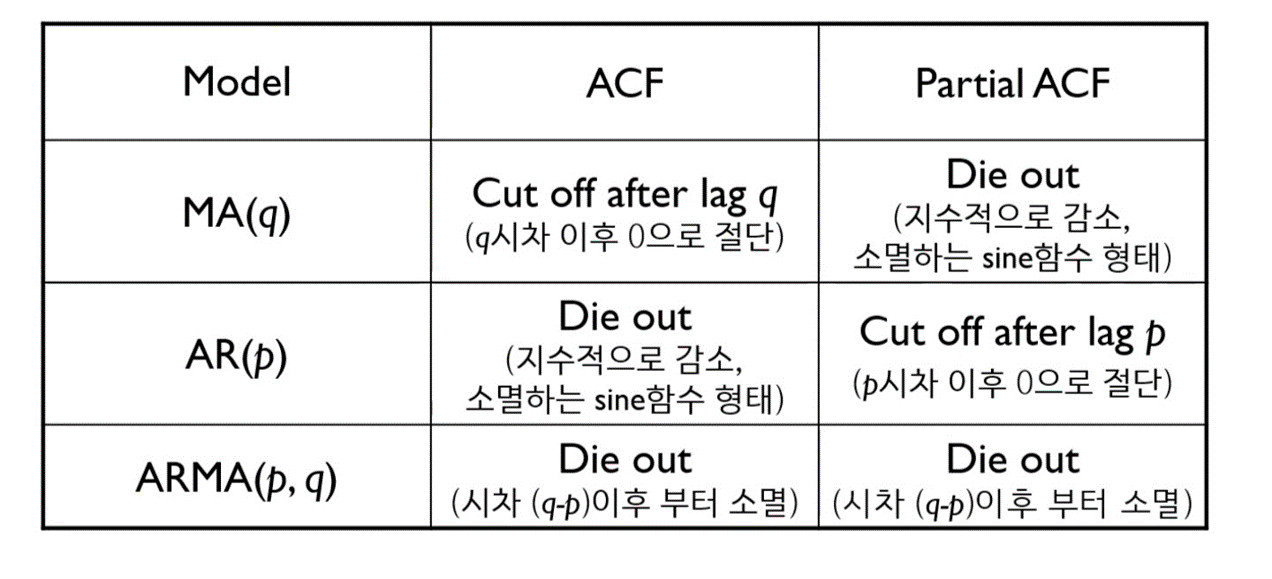

###3.Estimate parameter

In [18]:
# ARIMA model fitting
# The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters to use.

model = ARIMA(train_data.values, order=(1,0,0))
model_fit = model.fit()
model_fit.summary()

# Q1) AIC score 17만?? 이렇게 커도 되나?
# Q2) 차분 안할시 AIC score 18만?? 이렇게 커도 되나?

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  901
Model:                     ARMA(1, 0)   Log Likelihood               -6329.346
Method:                       css-mle   S.D. of innovations            271.997
Date:                Tue, 17 Aug 2021   AIC                          12664.693
Time:                        06:43:55   BIC                          12679.103
Sample:                             0   HQIC                         12670.197
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        675.5911     13.876     48.689      0.000     648.395     702.787
ar.L1.y        0.3473      0.031     11.121      0.000       0.286       0.409
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.8791           +0.0000j            2.8791            0.0000
-----------------------------------------------------------------------------
"""

In [19]:
# from pmdarima.arima import auto_arima

In [20]:
# model_arima= auto_arima(train_data.values,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=10,max_q=10,start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=10, m=4,suppress_warnings=True,stepwise=False,seasonal=True)

##4.ARIMA

Diagonisis check

In [21]:
# # Parameter search

# print('Examples of parameter combination for Seasonal ARIMA')
# p = range(0, 3)
# d = range(1, 2)
# q = range(0, 3)
# pdq = list(itertools.product(p,d,q))

# aic = []
# params=[] # optimal parameter순서 맞추려고 추가함
# for i in pdq:
#   try:
#     model = ARIMA(train_data.values, order = (i))
#     model_fit = model.fit()
#     print(f'ARIMA : {i} >> AIC : {round(model_fit.aic, 2)}')
#     aic.append(round(model_fit.aic,2))
#     params.append(i) # optimal parameter순서 맞추려고 추가함
#   except:
#     continue

#     # order = (2,1,1) 인 경우 계산이 안되어 예외처리함

#     # 결과 
# #     Examples of parameter combination for Seasonal ARIMA
# # ARIMA : (0, 1, 0) >> AIC : 13004.43
# # ARIMA : (0, 1, 1) >> AIC : 12713.58
# # ARIMA : (0, 1, 2) >> AIC : 12642.34
# # ARIMA : (1, 1, 0) >> AIC : 12924.95
# # ARIMA : (1, 1, 1) >> AIC : 12650.25
# # ARIMA : (1, 1, 2) >> AIC : 12644.32
# # ARIMA : (2, 1, 0) >> AIC : 12827.47
# # ARIMA : (2, 1, 1) >> AIC : 12644.75
# # ARIMA : (2, 1, 2) >> AIC : 12646.21

In [22]:
# Search optimal parameters

# optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal = [((0, 1, 2), 12642.34)]

In [23]:
model_opt = ARIMA(train_data.values, order = optimal[0][0])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  900
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -6317.169
Method:                       css-mle   S.D. of innovations            270.143
Date:                Tue, 17 Aug 2021   AIC                          12642.338
Time:                        06:43:55   BIC                          12661.548
Sample:                             1   HQIC                         12649.676
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2046      0.480     -0.426      0.670      -1.146       0.737
ma.L1.D.y     -0.6422      0.032    -20.290      0.000      -0.704      -0.580
ma.L2.D.y     -0.3060      0.032     -9.471      0.000      -0.369      -0.243
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0409           +0.0000j            1.0409            0.0000
MA.2           -3.1397           +0.0000j            3.1397            0.5000
-----------------------------------------------------------------------------
"""

use Model to forecast

In [24]:
prediction = model_opt_fit.forecast(len(test_data))
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.forecast.html#statsmodels.tsa.arima_model.ARIMAResults.forecast

# predicted_value = prediction[0]
# predicted_lb = prediction[2][:,0]
# predicted_ub = prediction[2][:,1]


# predict_index = list(test_data.index)
# r2 = r2_score(test_data, predicted_value)

In [25]:
test_data['ARIMA'] = prediction[0]

In [37]:
test_data.head()

,solar_result,ARIMA,SARIMA
day,,,
2019-11-19,727.92,594.208137,597.105373
2019-11-20,780.72,613.311745,597.105373
2019-11-21,714.48,613.107173,597.105373
2019-11-22,678.96,612.902601,597.105373
2019-11-23,672.72,612.698029,597.105373


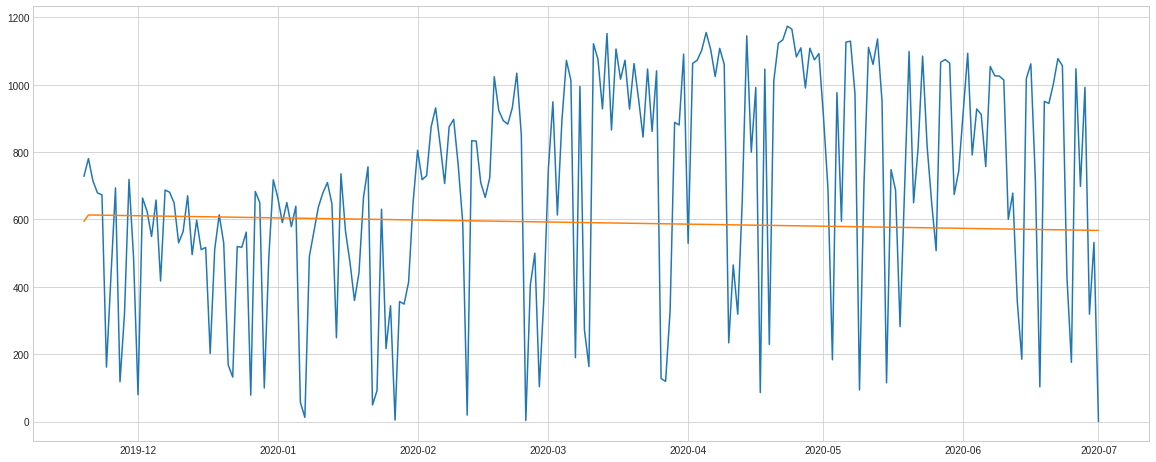

In [27]:
plt.figure(figsize=(20,8))
plt.plot(test_data)

##5.SARIMA

In [29]:
model_SARIMA_4 = SARIMAX(train_data.values, order=(2, 1, 2), seasonal_order=(1,0,0,4))
model_SARIMA_4_fit = model_SARIMA_4.fit()
model_SARIMA_4_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  901
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 4)   Log Likelihood               -6316.262
Date:                            Tue, 17 Aug 2021   AIC                          12644.524
Time:                                    06:44:08   BIC                          12673.338
Sample:                                         0   HQIC                         12655.531
                                            - 901                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3219      0.227     -1.419      0.156      -0.766       0.123
ar.L2          0.1148      0.088      1.302      0.193      -0.058       0.288
ma.L1         -0.3243      0.222     -1.462      0.144      -0.759       0.111
ma.L2         -0.6252      0.219     -2.851      0.004      -1.055      -0.195
ar.S.L4        0.0668      0.039      1.725      0.084      -0.009       0.143
sigma2      7.282e+04   3719.123     19.581      0.000    6.55e+04    8.01e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                62.97
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                            -0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
model_SARIMA_12 = SARIMAX(train_data.values, order=(2, 1, 2), seasonal_order=(1,0,0,12))
model_SARIMA_12_fit = model_SARIMA_12.fit()
model_SARIMA_12_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  901
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 12)   Log Likelihood               -6317.072
Date:                             Tue, 17 Aug 2021   AIC                          12646.143
Time:                                     06:44:13   BIC                          12674.958
Sample:                                          0   HQIC                         12657.151
                                             - 901                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1073      0.324      0.331      0.740      -0.528       0.743
ar.L2         -0.0341      0.107     -0.318      0.751      -0.244       0.176
ma.L1         -0.7464      0.323     -2.313      0.021      -1.379      -0.114
ma.L2         -0.2063      0.313     -0.658      0.510      -0.821       0.408
ar.S.L12       0.0177      0.034      0.522      0.602      -0.049       0.084
sigma2      7.296e+04   3716.114     19.634      0.000    6.57e+04    8.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                63.31
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                            -0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
model_SARIMA_24 = SARIMAX(train_data.values, order=(2, 1, 2), seasonal_order=(1,0,0,24))
model_SARIMA_24_fit = model_SARIMA_12.fit()
model_SARIMA_24_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  901
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 12)   Log Likelihood               -6317.072
Date:                             Tue, 17 Aug 2021   AIC                          12646.143
Time:                                     06:44:15   BIC                          12674.958
Sample:                                          0   HQIC                         12657.151
                                             - 901                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1073      0.324      0.331      0.740      -0.528       0.743
ar.L2         -0.0341      0.107     -0.318      0.751      -0.244       0.176
ma.L1         -0.7464      0.323     -2.313      0.021      -1.379      -0.114
ma.L2         -0.2063      0.313     -0.658      0.510      -0.821       0.408
ar.S.L12       0.0177      0.034      0.522      0.602      -0.049       0.084
sigma2      7.296e+04   3716.114     19.634      0.000    6.57e+04    8.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                63.31
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                            -0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

seasonal 주기를 바꾸어도 AIC가 크게 변경되지 않음

In [32]:
model_SARIMA_fit = model_SARIMA_24_fit

In [33]:
prediction_SARIMA = model_SARIMA_fit .forecast(len(test_data))

In [34]:
test_data['SARIMA'] = prediction_SARIMA[0]

In [35]:
test_data.head(10)

,solar_result,ARIMA,SARIMA
day,,,
2019-11-19,727.92,594.208137,597.105373
2019-11-20,780.72,613.311745,597.105373
2019-11-21,714.48,613.107173,597.105373
2019-11-22,678.96,612.902601,597.105373
2019-11-23,672.72,612.698029,597.105373
2019-11-24,161.52,612.493458,597.105373
2019-11-25,433.92,612.288886,597.105373
2019-11-26,693.60,612.084314,597.105373
2019-11-27,118.32,611.879742,597.105373


In [36]:
import plotly.graph_objects as go

f = go.FigureWidget()
set_period = test_data['2020-05-01 00:00:00':]
f.update_layout(plot_bgcolor='white')
f.add_scatter(y=set_period['solar_result'],x = set_period.index, name = 'Real result');
f.add_scatter(y=set_period['ARIMA'],x = set_period.index, name = 'ARIMA');
f.add_scatter(y=set_period['SARIMA'],x = set_period.index, name = 'SARIMA');
f.show()